In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import *

In [ ]:
def ma(array: np.array, window: int, progress=trange) -> np.array:
    result = np.array([],dtype="float64")
    assert window > 1, "Window is too small!"
    assert len(array) > window, "Array passed to MA is too small!"
    s = sum(array[:window])
    for i in progress(window, len(array), 1):
            # NumPy? Nice.
            result=np.append(result, [float(s)/float(window)])
            s -= array[i-window]
            s += array[i]
    return result

In [ ]:
data = pd.read_csv("data/USDCHF.csv")

In [ ]:
plt.plot(data)
plt.grid()
plt.show()

In [ ]:
data.head()

In [ ]:
# Build candles
parse_date = lambda x: datetime.datetime.strptime(x.split(".")[0],"%Y-%m-%dT%H:%M:%S")
def build_candles(data,build_for="OPEN", frame=300):
    assert len(data) > 0
    d,o,h,l,c = [],[],[],[],[]
    current_time = parse_date(data["TIME"][0])
    o.append(data[build_for][0])
    h.append(data[build_for][0])
    l.append(data[build_for][0])
    c.append(data[build_for][0])
    d.append(data["TIME"][0])
    dates = []
    for i in trange(len(data)):
        tm = parse_date(data["TIME"][i])
        dt = tm - current_time
        if dt.seconds>=frame:
            # new candle
            current_time=tm
            d.append(data["TIME"][i])
            o.append(data[build_for][i])
            h.append(data[build_for][i])
            l.append(data[build_for][i])
            c.append(data[build_for][i])
        else:
            price = data[build_for][i]
            if price > h[-1]:
                h[-1] = price
            if price < l[-1]:
                l[-1] = price
            c[-1] = price
    return d,o,h,l,c
            

In [ ]:
d,o,h,l,c = build_candles(data)

In [ ]:
df = pd.DataFrame()
df.insert(0,"DATE", d[100:])
df.set_index("DATE")
df.insert(1,"OPEN", o[100:])
df.insert(2,"HIGH", h[100:])
df.insert(3,"LOW", l[100:])
df.insert(4,"CLOSE", c[100:])
for i in tnrange(5,100):
    df.insert(0, "OPEN_MA%d"%i, ma(o,i, progress=range)[100-i:])
    df.insert(0, "HIGH_MA%d"%i, ma(h,i, progress=range)[100-i:])
    df.insert(0, "LOW_MA%d"%i, ma(l,i, progress=range)[100-i:])
    df.insert(0, "CLOSE_MA%d"%i, ma(c,i, progress=range)[100-i:])

In [ ]:
df.to_csv(f"data/{data['SYM'][0]}_ma.csv")
# df = pd.read_csv("data/USDCHF_ma.csv")

In [ ]:
plt.plot(df["OPEN_MA99"][:200])
plt.plot(df["OPEN"][:200])
plt.grid()
plt.show()

In [ ]:
build_by = "CLOSE"
eps = 5*10**-5
Y = np.array([])
c_1 = 0
c_2 = 0
c_3 = 0
for i in tnrange(1,len(df),1):
    if df[build_by][i]-df[build_by][i-1] > eps:
        Y = np.append(Y, [1])
        c_1 += 1
    elif df[build_by][i-1]-df[build_by][i] > eps:
        Y = np.append(Y, [-1])
        c_2 += 1
    else:
        Y = np.append(Y, [0])
        c_3 += 1
print("Class 1: %.3f%%"%(100.0*c_1/len(df)))
print("Class 2: %.3f%%"%(100.0*c_2/len(df)))
print("Class 3: %.3f%%"%(100.0*c_3/len(df)))

In [ ]:
# Normalize df
df = (df-df.mean())/df.std()

In [ ]:
df2=df[:-1]
df2.insert(0,"CLASS",Y)
df2.to_csv(f"data/{data['SYM'][0]}_normalized.csv")

In [26]:
df = pd.read_csv("data/USD_CHF_normalized.csv")
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from sklearn.model_selection import train_test_split <-- do not work on aarch64

In [27]:
cuda=torch.cuda.is_available()
if cuda:
    print("Using CUDA")
    device = torch.device("cuda:0")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using CUDA


In [28]:
df = df.drop(columns=["Unnamed: 0"])
df = df.dropna(axis=1, how='all')

In [29]:
df.head()

,CLASS,CLOSE,CLOSE_MA10,CLOSE_MA11,CLOSE_MA12,CLOSE_MA13,CLOSE_MA14,CLOSE_MA15,CLOSE_MA16,CLOSE_MA17,...,OPEN_MA90,OPEN_MA91,OPEN_MA92,OPEN_MA93,OPEN_MA94,OPEN_MA95,OPEN_MA96,OPEN_MA97,OPEN_MA98,OPEN_MA99
0,-1.0,0.268902,0.298462,0.298857,0.299669,0.300866,0.301595,0.301284,0.301635,0.301553,...,0.309046,0.308151,0.307385,0.307011,0.306521,0.306225,0.305926,0.305797,0.305593,0.305360
1,-1.0,0.262262,0.295058,0.295762,0.296347,0.297288,0.298569,0.299402,0.299247,0.299696,...,0.309185,0.308435,0.307557,0.306805,0.306441,0.305962,0.305674,0.305384,0.305262,0.305065
2,-1.0,0.248982,0.290740,0.292063,0.292956,0.293711,0.294773,0.296135,0.297067,0.297058,...,0.309388,0.308756,0.308019,0.307154,0.306414,0.306058,0.305588,0.305307,0.305024,0.304905
3,-1.0,0.232381,0.284762,0.286929,0.288458,0.289559,0.290502,0.291706,0.293174,0.294224,...,0.309490,0.308820,0.308200,0.307477,0.306627,0.305900,0.305553,0.305092,0.304819,0.304544
4,1.0,0.212461,0.275462,0.279985,0.282369,0.284129,0.285460,0.286612,0.287983,0.289583,...,0.309416,0.308810,0.308155,0.307548,0.306840,0.306005,0.305293,0.304955,0.304505,0.304241


In [30]:
X = np.array(df)
X = np.delete(X, len(X[0])-1, 1)
Y = np.array(df["CLASS"])

In [31]:
X.shape

(50159, 384)

In [32]:
Y.shape

(50159,)

In [33]:
# We should NOT shuffle train/test data, since it may bias backtesting result
X_train, X_test, Y_train, Y_test = [],[],[],[]
TRAIN_FACTOR = 0.7
for i in tnrange(len(df)):
    if i < TRAIN_FACTOR*len(df):
        X_train.append(X[i])
        Y_train.append(Y[i])
    else:
        X_test.append(X[i])
        Y_test.append(Y[i]) 
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

  0%|          | 0/50159 [00:00<?, ?it/s]

In [37]:
model = nn.Sequential(
    nn.Linear(384,384),
    nn.Tanh(),
    nn.Linear(384,285),
    nn.LeakyReLU(),
    nn.Linear(285,185),
    nn.Tanh(),
    nn.Linear(185,85),
    nn.ELU(),
    nn.Linear(85,3),
    nn.Softmax()
)
criterion = nn.CrossEntropyLoss().to(device) # <--- WORST LOSS IMPLEMENTATION EVER!!1
optimizer = optim.SGD(model.parameters(), lr = 0.01)
model = model.to(device)

In [38]:
BATCH_SIZE = 128
N_EPOCHS = 100
def get_targets(Y):
    Y_targets = []
    for x in Y:
        assert x in [-1,0,1]
        if x==-1:
            Y_targets.append([1,0,0])
        if x==0:
            Y_targets.append([0,1,0])
        if x==1:
            Y_targets.append([0,0,1])
    return Y_targets

In [39]:
losses = []
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], BATCH_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for j in range(BATCH_SIZE):
        x = torch.Tensor(sample_x[j]).to(device)
        target = torch.Tensor([sample_y[j]+1]).type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        output = model(x)
        #print(output)
        output = output.reshape((1,3)).float()
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= BATCH_SIZE
    losses.append(avg_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
losses[:5]

[1.0997621454298496,
 1.0932670030742884,
 1.099083243869245,
 1.0864075860008597,
 1.0906901392154396]

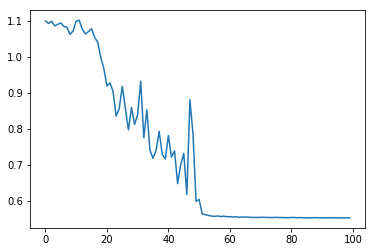

In [41]:
plt.plot(losses)
plt.show()

In [45]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in tnrange(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float().to(device)
        y = Y[i]
        _y = model(x)
        if _y[0] > _y[1] and _y[0] > _[2]:
            cls = -1
        elif _y[1] > _y[2] and _y[1]>_y[0]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [46]:
acc(X_test, Y_test)

  0%|          | 0/15047 [00:00<?, ?it/s]

0.6569415830398087

In [48]:
# TODO: Deeper anlysis of misclassification, dataset improvements(corelation, lags, etc.)